In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf

from arch import arch_model

from utils import *

## Loess (STL)

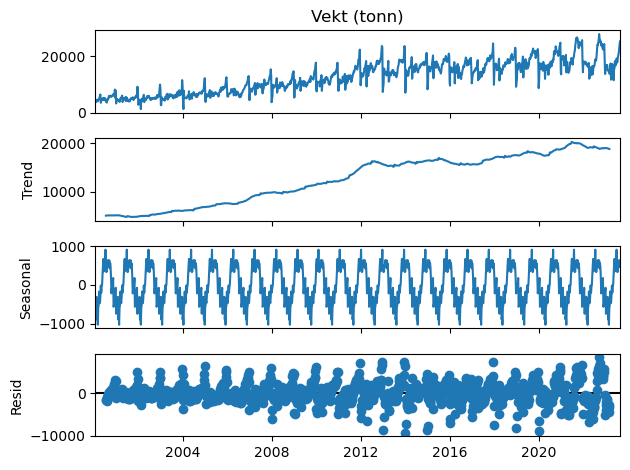

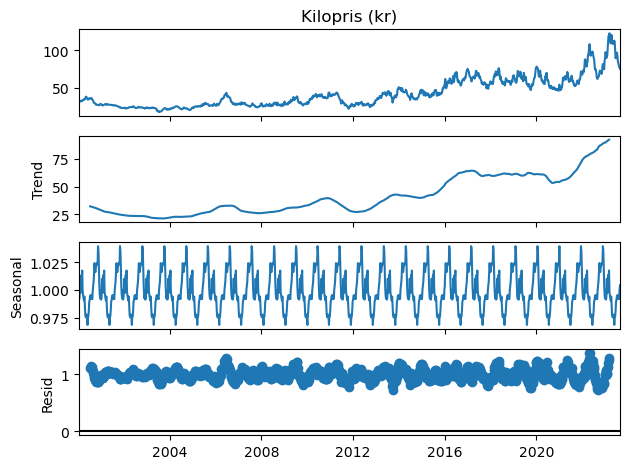

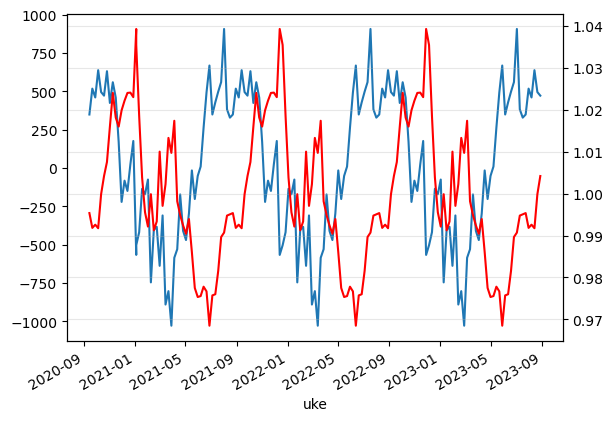

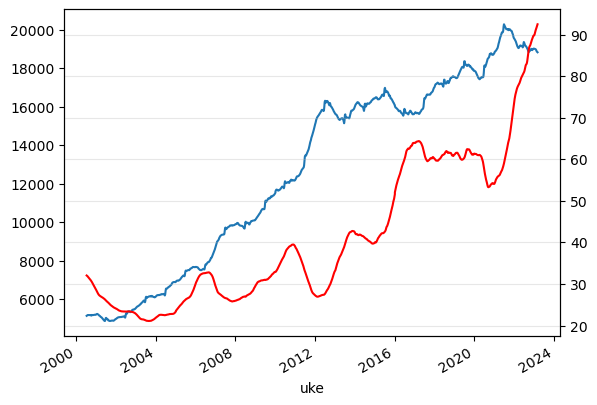

In [94]:
data_URL = 'https://www.ssb.no/statbank/sq/10085910'

data = import_salmon_data(data_URL)


STL_volume = seasonal_decompose(
    data['Vekt (tonn)'], model="additive", period=50
)

volume_plot = STL_volume.plot()

STL_price = seasonal_decompose(
    data['Kilopris (kr)'], model="multiplicative", period=50
)

price_plot = STL_price.plot()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

seasonal = pd.DataFrame({'Volume':STL_volume.seasonal, 'Price':STL_price.seasonal})

seasonal['Volume'].iloc[-52*3:].plot(ax=ax1)
seasonal['Price'].iloc[-52*3:].plot(ax=ax2, color='red')
ax2.grid(alpha=0.3)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

trend = pd.DataFrame({'Volume':STL_volume.trend, 'Price':STL_price.trend})

trend['Volume'].plot(ax=ax1)
trend['Price'].plot(ax=ax2, color='red')
ax2.grid(alpha=0.3)

cross_corr = ccf(seasonal['Price'], seasonal['Volume'])


Text(0.5, 0, 'Lags')

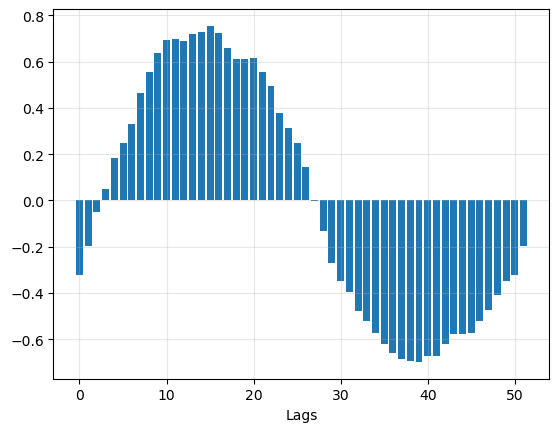

In [89]:
plt.grid(alpha=0.3)
plt.bar(range(52), cross_corr[:52])
plt.xlabel('Lags')

## GARCH

In [105]:

p_yield = np.log(data['Kilopris (kr)'] / data['Kilopris (kr)'].shift())

forecast_horizon = 10
rolling_predictions = []

for i in range(len(p_yield) - forecast_horizon + 1):
    train_data = p_yield.iloc[:i + forecast_horizon]
    model = arch_model(train_data, vol='Garch', p=1, q=1)
    results = model.fit(disp='off')
    forecast = results.forecast(start=i + forecast_horizon - 1, horizon=forecast_horizon)
    rolling_predictions.append(forecast.variance.values[-1, :][0])

rolling_predictions = pd.Series(rolling_predictions, index=p_yield.index[forecast_horizon - 1:])

c:\Users\joneh\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007318. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\joneh\anaconda3\Lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
c:\Users\joneh\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the opt

<Axes: xlabel='uke', ylabel='Price [NOK]'>

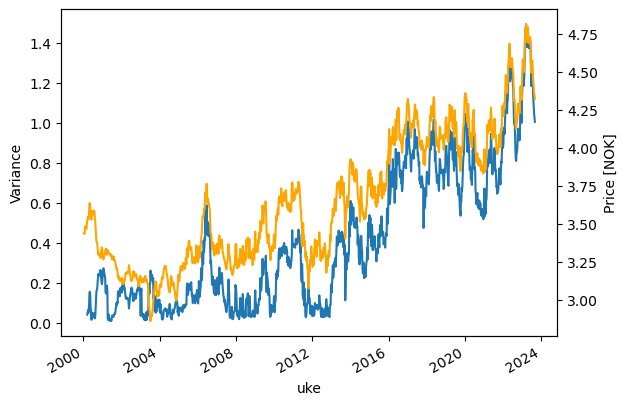

In [107]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

rolling_predictions.plot(ax=ax1, ylabel='Variance')
p_yield.plot(ax=ax2, color='orange', ylabel='Price [NOK]')